In [1]:
# %% [markdown]
# # Housing Starts: Advanced EDA → Features → Modeling (Per-province & Pooled)

# %%
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from typing import Dict, List, Tuple

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Optional boosters (safe fallbacks if not installed)
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    import lightgbm as lgb
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

try:
    from catboost import CatBoostRegressor
    HAS_CAT = True
except Exception:
    HAS_CAT = False

# --- Config ---
DATA_PATH = "data/housing_adequacy_dataset.csv"
SPLIT_POINT = "2020Q1"   # train < split, test >= split
AHS = 2.5
RANDOM_STATE = 42

PROVINCES_ORDER = ["can","nl","pe","ns","nb","qc","on","mb","sk","ab","bc"]
PROVINCE_NAMES = {
    "can": "Canada", "nl": "Newfoundland and Labrador", "pe": "Prince Edward Island",
    "ns": "Nova Scotia", "nb": "New Brunswick", "qc": "Quebec", "on": "Ontario",
    "mb": "Manitoba", "sk": "Saskatchewan", "ab": "Alberta", "bc": "British Columbia"
}

# Metrics
def mae(y_true, y_pred): return np.mean(np.abs(y_true - y_pred))
def rmse(y_true, y_pred): return np.sqrt(np.mean((y_true - y_pred)**2))
def smape(y_true, y_pred, eps=1e-12):
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return np.mean(2.0*np.abs(y_pred - y_true)/denom)
def mase(y_true, y_pred, y_train, seasonality=4):
    y_train = np.asarray(y_train)
    if len(y_train) <= seasonality: return np.nan
    diffs = np.abs(y_train[seasonality:] - y_train[:-seasonality])
    scale = np.mean(diffs) if len(diffs) else np.nan
    if scale == 0 or np.isnan(scale): return np.nan
    return mae(y_true, y_pred) / scale


In [2]:
# %%
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Could not find {DATA_PATH}.\n"
        f"Run your earlier script that saved df to this path, or update DATA_PATH."
    )

df = pd.read_csv(DATA_PATH)
df["quarter"] = pd.PeriodIndex(df["quarter"], freq="Q")
df = df.sort_values(["province","quarter"]).reset_index(drop=True)

print("Shape:", df.shape)
display(df.head())


Shape: (1573, 9)


,quarter,province,population,starts_saar,starts_saar_q,dwelling_starts,pop_change_q,needed_units_q,hai
0,1990Q1,ab,2520056.0,23.421667,5.855417,5855.416667,NaN,NaN,0.000000
1,1990Q2,ab,2532621.0,21.490333,5.372583,5372.583333,12565.0,5026.0,1.068958
2,1990Q3,ab,2547788.0,13.847000,3.461750,3461.750000,15167.0,6066.8,0.570606
3,1990Q4,ab,2563142.0,11.723333,2.930833,2930.833333,15354.0,6141.6,0.477210
4,1991Q1,ab,2572947.0,8.494667,2.123667,2123.666667,9805.0,3922.0,0.541475


In [3]:
# %%
def _to_datetime_from_period(q: pd.Series) -> pd.Series:
    return q.dt.to_timestamp()

def plot_time_series_clean(
    df, col, title, ncols=3, provinces_order=None,
    height_per_row=2.6, width_per_col=4.0, year_tick_interval=2, rotation=30
):
    provinces = [p for p in (provinces_order or sorted(df["province"].unique()))
                 if p in df["province"].unique()]
    n = len(provinces); nrows = int(np.ceil(n/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(width_per_col*ncols, height_per_row*nrows), sharex=True)
    axes = np.array(axes).reshape(nrows, ncols)

    locator = mdates.YearLocator(base=year_tick_interval)
    formatter = mdates.DateFormatter('%Y')

    for i, p in enumerate(provinces):
        r,c = divmod(i, ncols); ax = axes[r,c]
        sub = df[df["province"]==p].sort_values("quarter")
        x = _to_datetime_from_period(sub["quarter"]); y = sub[col].values
        ax.plot(x, y, linewidth=1.6)
        ax.set_title(PROVINCE_NAMES.get(p, p), fontsize=10, pad=4)
        ax.grid(True, alpha=0.25); ax.margins(x=0.01)
        ax.xaxis.set_major_locator(locator); ax.xaxis.set_major_formatter(formatter)
        for label in ax.get_xticklabels():
            label.set_rotation(rotation); label.set_ha("right")
        if r < nrows-1: ax.tick_params(axis="x", labelbottom=False)

    for j in range(n, nrows*ncols): axes.flat[j].axis("off")
    fig.suptitle(title, y=0.98, fontsize=12); fig.tight_layout(); plt.show()

def plot_box_by_province_clean(
    df, col, title, provinces_order=None, use_symlog=True, linthresh=1.0, ylim_percentile=99
):
    provinces = [p for p in (provinces_order or sorted(df["province"].unique()))
                 if p in df["province"].unique()]
    labels = [PROVINCE_NAMES.get(p, p) for p in provinces]
    series = [df.loc[df["province"]==p, col].dropna() for p in provinces]

    all_vals = pd.concat(series) if len(series) else pd.Series(dtype=float)
    ylim = None
    if len(all_vals) and ylim_percentile:
        lo = np.nanpercentile(all_vals, 100-ylim_percentile)
        hi = np.nanpercentile(all_vals, ylim_percentile)
        ylim = (lo, hi)

    plt.figure(figsize=(max(8, 0.5*len(labels)+6), 3.6))
    plt.boxplot(series, labels=labels, showmeans=True, whis=(5,95))
    plt.xticks(rotation=20, ha="right"); plt.ylabel(col); plt.title(title)
    ax = plt.gca(); ax.grid(True, axis="y", alpha=0.3)
    if use_symlog:
        ax.set_yscale("symlog", linthresh=linthresh, linscale=1.0); ax.axhline(0, color="grey", lw=0.8, alpha=0.5)
    if ylim is not None and np.all(np.isfinite(ylim)):
        ax.set_ylim(ylim[0]-0.05*abs(ylim[0]), ylim[1]+0.05*abs(ylim[1]))
    plt.tight_layout(); plt.show()


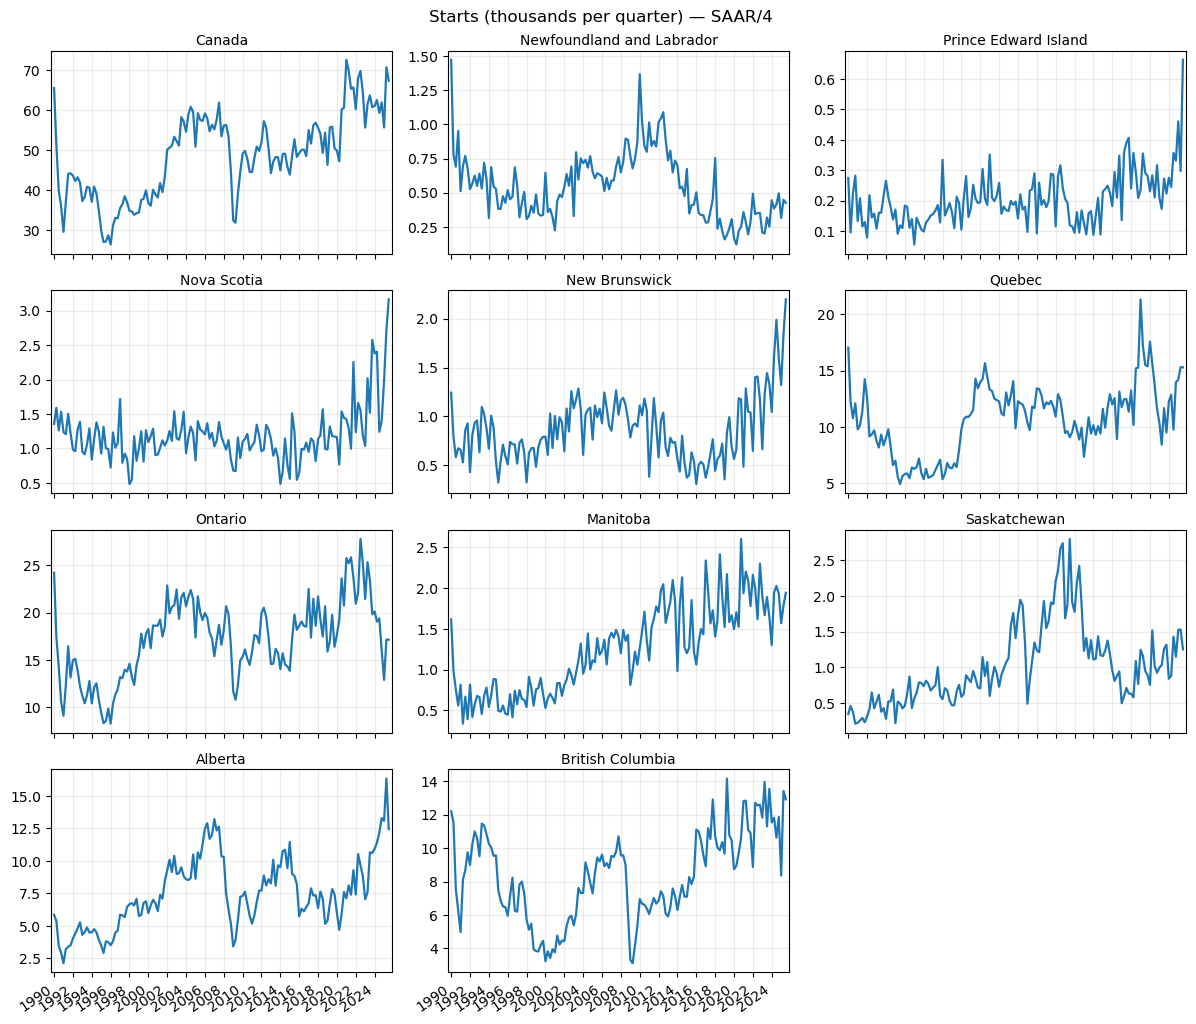

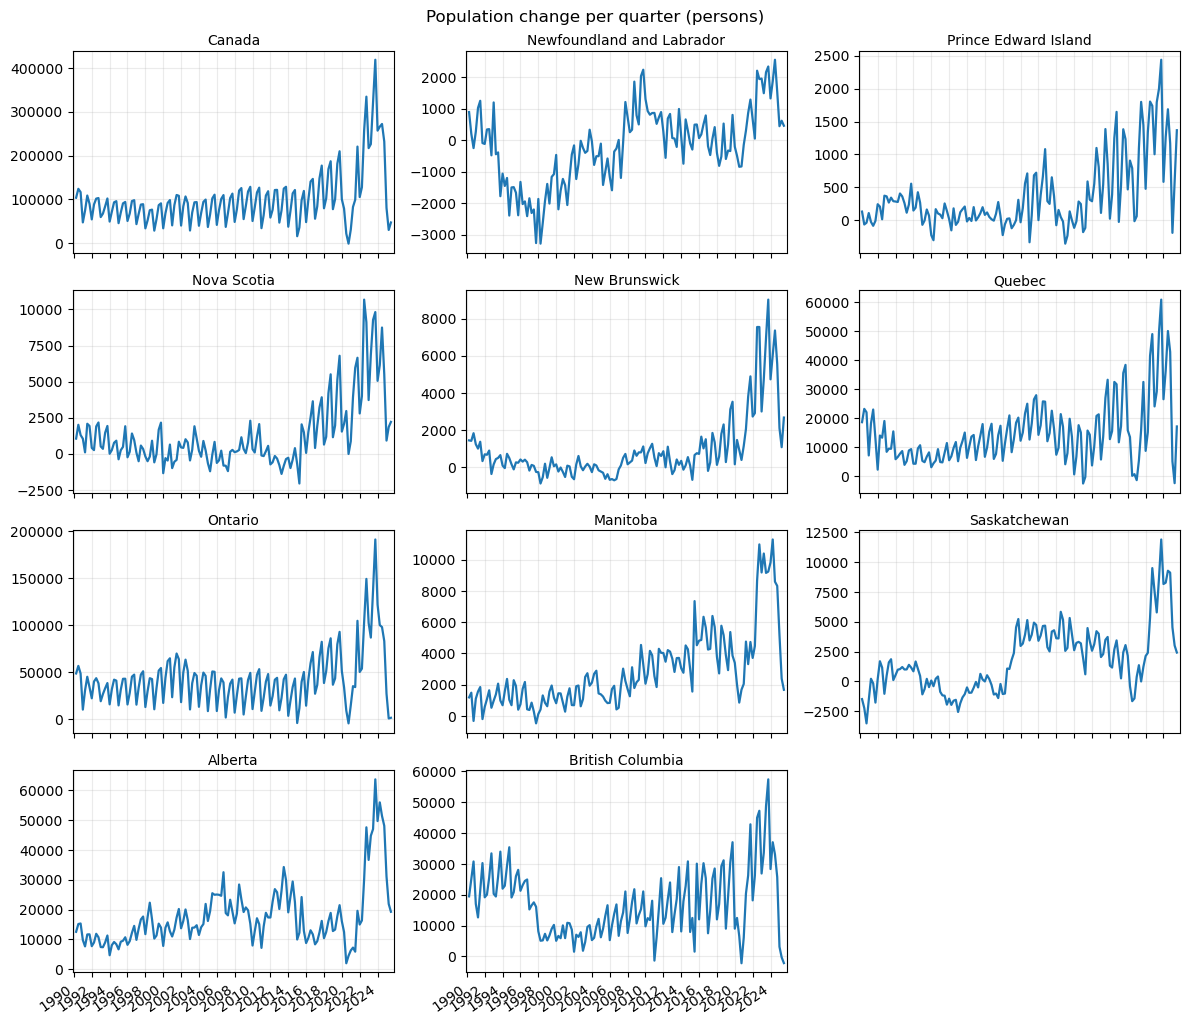

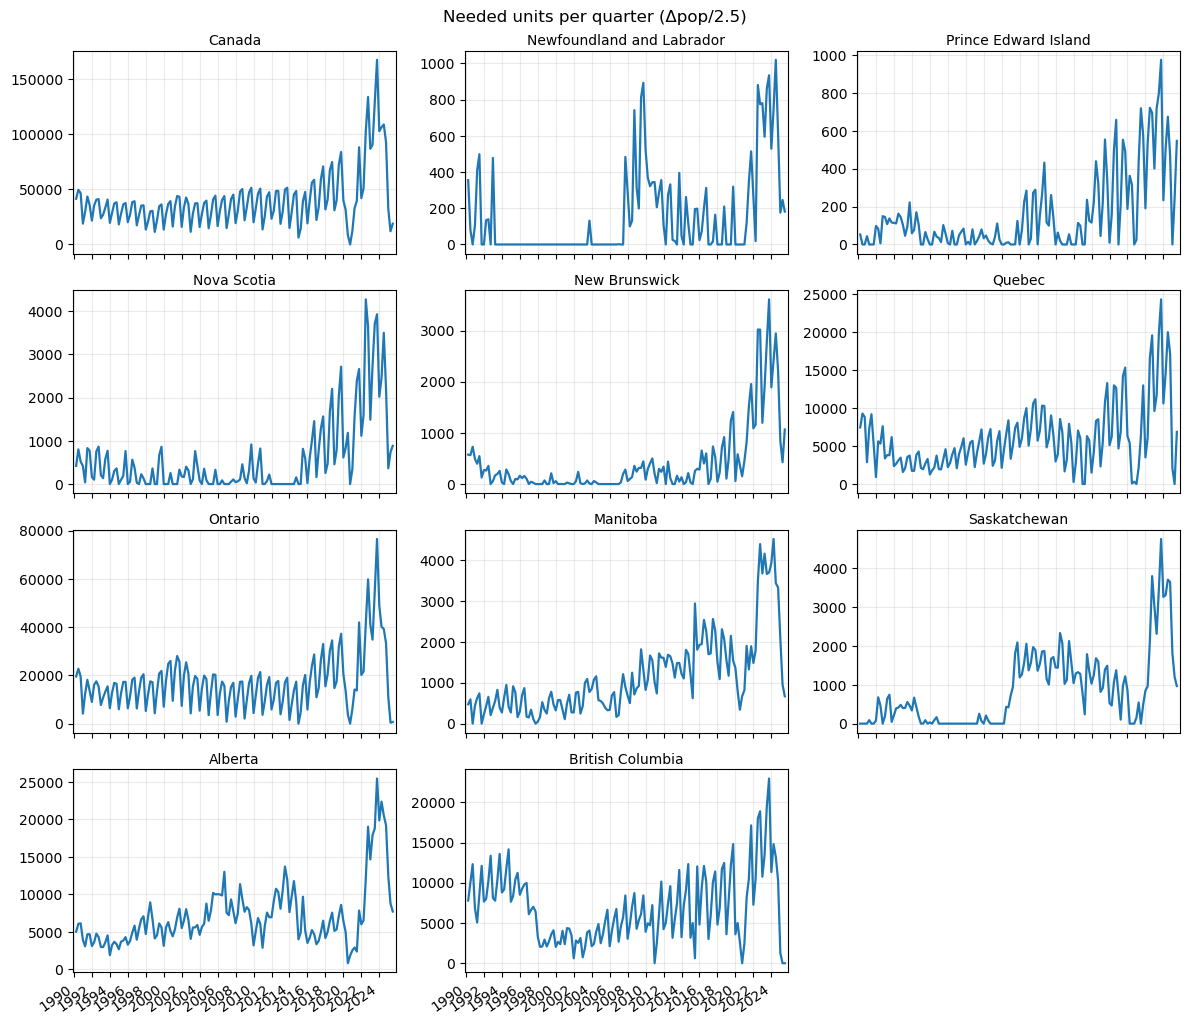

/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_12795/981625628.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(series, labels=labels, showmeans=True, whis=(5,95))


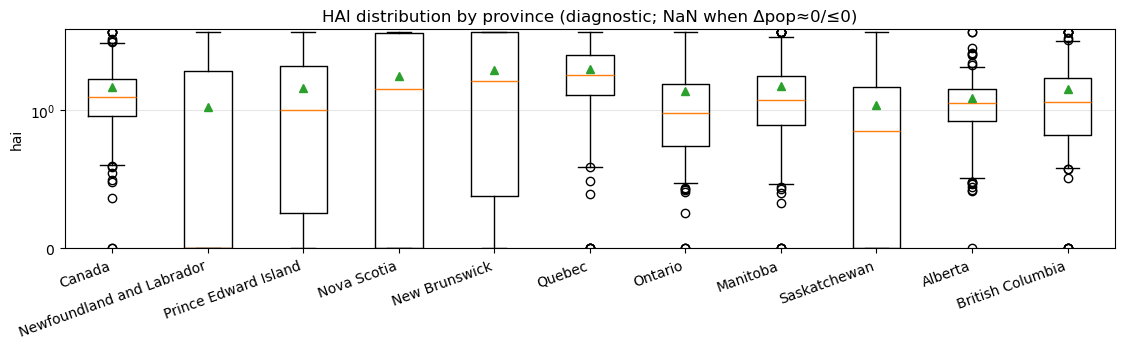

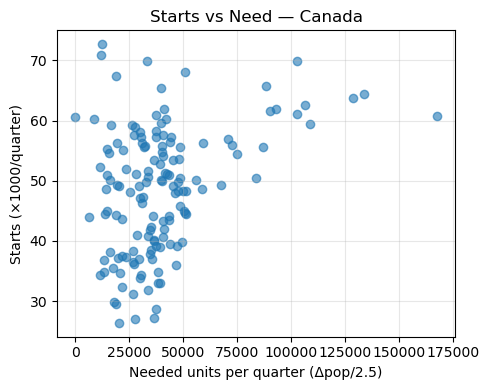

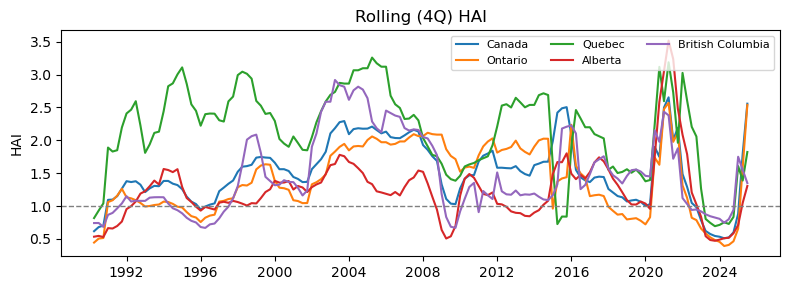

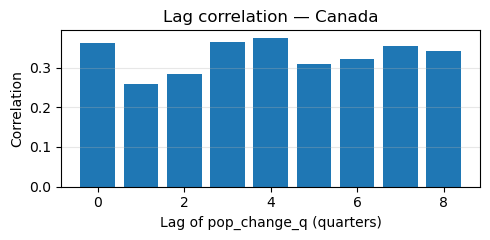

In [4]:
# %%
plot_time_series_clean(df, "starts_saar_q", "Starts (thousands per quarter) — SAAR/4",
                       ncols=3, provinces_order=PROVINCES_ORDER, year_tick_interval=2, rotation=35)

plot_time_series_clean(df, "pop_change_q", "Population change per quarter (persons)",
                       ncols=3, provinces_order=PROVINCES_ORDER, year_tick_interval=2, rotation=35)

plot_time_series_clean(df, "needed_units_q", f"Needed units per quarter (Δpop/{AHS})",
                       ncols=3, provinces_order=PROVINCES_ORDER, year_tick_interval=2, rotation=35)

plot_box_by_province_clean(
    df, "hai",
    "HAI distribution by province (diagnostic; NaN when Δpop≈0/≤0)",
    provinces_order=PROVINCES_ORDER, use_symlog=True, linthresh=1.0, ylim_percentile=99
)

def plot_scatter(df, province="can"):
    sub = df[(df["province"]==province) & df["needed_units_q"].notna() & df["starts_saar_q"].notna()]
    plt.figure(figsize=(5,4))
    plt.scatter(sub["needed_units_q"], sub["starts_saar_q"], alpha=0.6)
    plt.xlabel("Needed units per quarter (Δpop/2.5)"); plt.ylabel("Starts (×1000/quarter)")
    plt.title(f"Starts vs Need — {PROVINCE_NAMES.get(province, province)}"); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

plot_scatter(df, "can")

def plot_hai_trend(df, provinces=("can","on","qc","ab","bc")):
    plt.figure(figsize=(8,3))
    for p in provinces:
        sub = df[df["province"]==p].sort_values("quarter")
        x = _to_datetime_from_period(sub["quarter"])
        y = sub["hai"].rolling(4, min_periods=2).mean()
        plt.plot(x, y, label=PROVINCE_NAMES.get(p, p))
    plt.axhline(1, color="gray", ls="--", lw=1)
    plt.legend(ncol=3, fontsize=8); plt.title("Rolling (4Q) HAI"); plt.ylabel("HAI"); plt.tight_layout(); plt.show()

plot_hai_trend(df)

def lag_corr(df, province="can", max_lag=8):
    sub = df[df["province"]==province].dropna(subset=["starts_saar_q","pop_change_q"])
    lags = range(0, max_lag+1)
    corr = [sub["starts_saar_q"].corr(sub["pop_change_q"].shift(l)) for l in lags]
    plt.figure(figsize=(5,2.5)); plt.bar(lags, corr)
    plt.xlabel("Lag of pop_change_q (quarters)"); plt.ylabel("Correlation")
    plt.title(f"Lag correlation — {PROVINCE_NAMES.get(province, province)}"); plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout(); plt.show()

lag_corr(df, "can", max_lag=8)


In [5]:
# %%
def add_lags(df, cols: List[str], lags: List[int]) -> pd.DataFrame:
    """Lag each column by l steps per province (safe: uses only past info)."""
    out = df.sort_values(["province", "quarter"]).copy()
    for col in cols:
        for l in lags:
            out[f"{col}_lag{l}"] = out.groupby("province")[col].shift(l)
    return out


def add_calendar_features(df: pd.DataFrame) -> pd.DataFrame:
    """Add year and seasonal dummies."""
    out = df.copy()
    out["year"] = out["quarter"].dt.year
    out["quarter_num"] = out["quarter"].dt.quarter
    q_dummies = pd.get_dummies(out["quarter_num"], prefix="q", drop_first=True)
    out = pd.concat([out, q_dummies], axis=1)
    return out


def add_interactions_and_ratios(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add SAFE ratios/growths that depend only on past values.
    Avoid using current target (starts_saar_q) directly.
    """
    out = df.copy()

    safe_population = out["population"].replace({0: np.nan})
    denom_need = out["needed_units_q"].abs() >= 10  # same cutoff logic

    # --- lagged ratios ---
    out["starts_per_need_lag1"] = np.where(
        denom_need, out["starts_saar_q_lag1"] / (out["needed_units_q"] / 1000.0), np.nan
    )

    # --- growth from previous quarter ---
    out["starts_growth_lag1"] = out.groupby("province")["starts_saar_q"].pct_change().shift(1)

    # --- population change rate ---
    out["pop_change_rate_lag1"] = (out["pop_change_q"].shift(1) / safe_population).replace([np.inf, -np.inf], np.nan)

    return out


def add_rollings(df: pd.DataFrame, windows=(2, 4, 8)) -> pd.DataFrame:
    """
    Add *causal* rolling means: shifted by 1 so they only use past data.
    Example: ma4 at 2020Q2 uses data up to 2020Q1.
    """
    out = df.copy()
    for w in windows:
        out[f"starts_ma{w}"] = out.groupby("province")["starts_saar_q"].transform(
            lambda s: s.shift(1).rolling(w, min_periods=1).mean()
        )
        out[f"pop_change_ma{w}"] = out.groupby("province")["pop_change_q"].transform(
            lambda s: s.shift(1).rolling(w, min_periods=1).mean()
        )
        out[f"need_ma{w}"] = out.groupby("province")["needed_units_q"].transform(
            lambda s: s.shift(1).rolling(w, min_periods=1).mean()
        )
    return out


# %%
lag_cols = ["starts_saar_q", "pop_change_q", "needed_units_q"]
df_feat = add_lags(df, lag_cols, lags=[1, 2, 4])
df_feat = add_calendar_features(df_feat)
df_feat = add_interactions_and_ratios(df_feat)
df_feat = add_rollings(df_feat, windows=(2, 4, 8))
df_feat["province_code"] = df_feat["province"].astype("category").cat.codes

print("Enriched (causal) shape:", df_feat.shape)
display(df_feat.tail(3))


Enriched (causal) shape: (1573, 36)


,quarter,province,population,starts_saar,starts_saar_q,dwelling_starts,pop_change_q,needed_units_q,hai,starts_saar_q_lag1,...,starts_ma2,pop_change_ma2,need_ma2,starts_ma4,pop_change_ma4,need_ma4,starts_ma8,pop_change_ma8,need_ma8,province_code
1570,2025Q1,sk,1261524.0,6.101667,1.525417,1525.416667,4541.0,1816.4,0.839802,1.147667,...,1.288375,9196.0,3678.4,1.075167,8707.75,3483.1,1.113813,8586.000,3434.40,10
1571,2025Q2,sk,1264537.0,6.118667,1.529667,1529.666667,3013.0,1205.2,1.269222,1.525417,...,1.336542,6828.0,2731.2,1.246375,7802.00,3120.8,1.180125,8210.500,3284.20,10
1572,2025Q3,sk,1266959.0,5.009000,1.252250,1252.250000,2422.0,968.8,1.292578,1.529667,...,1.527542,3777.0,1510.8,1.407958,6486.50,2594.6,1.241948,7864.125,3145.65,10


In [6]:
# %%
def sanitize_features(df: pd.DataFrame, cols: List[str], clip_quantiles=None) -> pd.DataFrame:
    out = df.copy()
    out.replace([np.inf, -np.inf], np.nan, inplace=True)
    if clip_quantiles is not None:
        lo, hi = clip_quantiles
        for c in cols:
            if c in out.columns:
                ql = out[c].quantile(lo)
                qh = out[c].quantile(hi)
                out[c] = out[c].clip(ql, qh)
    return out

# %%
TARGET = "starts_saar_q"

BASE_FEATS = [
    # exogenous contemporaneous vars (OK if you can forecast/provide them)
    "pop_change_q", "needed_units_q",

    # safe lags
    "starts_saar_q_lag1", "starts_saar_q_lag2", "starts_saar_q_lag4",
    "pop_change_q_lag1", "needed_units_q_lag1",

    # seasonality/time
    "year", "q_2", "q_3", "q_4",

    # causal rolling means
    "starts_ma2", "starts_ma4", "starts_ma8",
    "pop_change_ma2", "pop_change_ma4", "pop_change_ma8",
    "need_ma2", "need_ma4", "need_ma8",

    # lagged interaction ratios
    "starts_per_need_lag1", "starts_growth_lag1", "pop_change_rate_lag1",
]

POOLED_FEATS = BASE_FEATS + ["province_code"]

all_feats_for_model = list(set(BASE_FEATS + POOLED_FEATS))
df_feat = sanitize_features(df_feat, list(set(BASE_FEATS + POOLED_FEATS)), clip_quantiles=None)

def check_bad_values(df: pd.DataFrame, cols: List[str]):
    bad = []
    for c in cols:
        s = df[c]
        n_inf = np.isinf(s.to_numpy(), where=~s.isna().to_numpy()).sum()
        n_nan = s.isna().sum()
        if n_inf or n_nan:
            bad.append((c, int(n_inf), int(n_nan)))
    diag = pd.DataFrame(bad, columns=["col","n_inf","n_nan"]).sort_values(["n_inf","n_nan"], ascending=False)
    return diag

diag = check_bad_values(df_feat, list(set(BASE_FEATS + POOLED_FEATS)))
display(diag.head(10))


,col,n_inf,n_nan
13,starts_per_need_lag1,262,262
8,starts_saar_q_lag4,44,44
4,pop_change_q_lag1,22,22
5,need_ma2,22,22
6,pop_change_ma4,22,22
7,need_ma8,22,22
10,starts_saar_q_lag2,22,22
11,pop_change_ma8,22,22
14,pop_change_ma2,22,22
17,need_ma4,22,22


In [7]:
# %%
def chrono_split(dfX: pd.DataFrame, split_point: str):
    tr = dfX[dfX["quarter"] < split_point].copy()
    te = dfX[dfX["quarter"] >= split_point].copy()
    return tr, te

def build_model_registry():
    models = {
        "lr": Pipeline([("scaler", StandardScaler()), ("model", LinearRegression())]),
        "ridgecv": Pipeline([("scaler", StandardScaler()), ("model", RidgeCV(alphas=np.logspace(-3,3,21)))]),
        "elasticnetcv": Pipeline([("scaler", StandardScaler()),
                                  ("model", ElasticNetCV(l1_ratio=[.1,.3,.5,.7,.9,1.0],
                                                         alphas=np.logspace(-4,1,20),
                                                         max_iter=5000, random_state=RANDOM_STATE))]),
        "rf": RandomForestRegressor(n_estimators=600, random_state=RANDOM_STATE, n_jobs=-1),
        "gbr": GradientBoostingRegressor(n_estimators=800, learning_rate=0.03, max_depth=3, random_state=RANDOM_STATE),
    }
    if HAS_XGB:
        models["xgb"] = XGBRegressor(
            n_estimators=1000, learning_rate=0.03, max_depth=5,
            subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE, n_jobs=-1
        )
    if HAS_LGBM:
        models["lgbm"] = lgb.LGBMRegressor(
            n_estimators=1500, learning_rate=0.03, max_depth=-1,
            subsample=0.9, colsample_bytree=0.8, random_state=RANDOM_STATE, n_jobs=-1
        )
    if HAS_CAT:
        models["cat"] = CatBoostRegressor(
            depth=6, learning_rate=0.05, iterations=1200,
            random_seed=RANDOM_STATE, verbose=False, loss_function="MAE"
        )
    return models


In [8]:
# %%
def evaluate_models(
    data: pd.DataFrame, feature_cols: List[str], pooled: bool = False,
    split_point: str = SPLIT_POINT, seasonality: int = 4
):
    reg = build_model_registry()
    metrics = []
    preds_store = {}

    if pooled:
        use_cols = ["province", "quarter", TARGET] + feature_cols
        Xdf = data.dropna(subset=use_cols).copy()
        tr, te = chrono_split(Xdf, split_point)
        if tr.empty or te.empty:
            return pd.DataFrame(), {}

        X_tr, y_tr = tr[feature_cols].values, tr[TARGET].values
        X_te, y_te = te[feature_cols].values, te[TARGET].values

        preds_store["pooled"] = {}
        naive = te.get(f"{TARGET}_lag{seasonality}", pd.Series(index=te.index, data=np.nan)).values
        preds_store["pooled"]["seasonal_naive"] = pd.Series(naive, index=te.index)

        for name, mdl in reg.items():
            mdl.fit(X_tr, y_tr)
            yhat = mdl.predict(X_te)
            metrics.append({"province": "pooled", "model": name,
                            "MAE": mae(y_te, yhat), "RMSE": rmse(y_te, yhat),
                            "sMAPE(%)": smape(y_te, yhat)*100,
                            "MASE": mase(y_te, yhat, y_train=y_tr, seasonality=seasonality)})
            preds_store["pooled"][name] = pd.Series(yhat, index=te.index)

        blend_sources = [m for m in reg.keys() if m in preds_store["pooled"]]
        if "ridgecv" in blend_sources and ("xgb" in blend_sources or "lgbm" in blend_sources or "cat" in blend_sources):
            booster = "xgb" if "xgb" in blend_sources else ("lgbm" if "lgbm" in blend_sources else "cat")
            yhat = 0.5*preds_store["pooled"]["ridgecv"].values + 0.5*preds_store["pooled"][booster].values
            metrics.append({"province":"pooled","model":f"blend(ridgecv+{booster})",
                            "MAE": mae(y_te, yhat), "RMSE": rmse(y_te, yhat),
                            "sMAPE(%)": smape(y_te, yhat)*100,
                            "MASE": mase(y_te, yhat, y_train=y_tr, seasonality=seasonality)})
            preds_store["pooled"][f"blend(ridgecv+{booster})"] = pd.Series(yhat, index=te.index)

        metrics.append({"province":"pooled","model":"seasonal_naive",
                        "MAE": mae(y_te, naive), "RMSE": rmse(y_te, naive),
                        "sMAPE(%)": smape(y_te, naive)*100,
                        "MASE": mase(y_te, naive, y_train=y_tr, seasonality=seasonality)})
        return pd.DataFrame(metrics), preds_store

    # per-province
    provinces = sorted(data["province"].unique(), key=lambda x: PROVINCES_ORDER.index(x) if x in PROVINCES_ORDER else 999)
    for p in provinces:
        sub = data[data["province"]==p].dropna(subset=feature_cols + [TARGET]).copy()
        if sub.empty: continue
        tr, te = chrono_split(sub, split_point)
        if tr.empty or te.empty: continue

        X_tr, y_tr = tr[feature_cols].values, tr[TARGET].values
        X_te, y_te = te[feature_cols].values, te[TARGET].values

        preds_store.setdefault(p, {})
        naive = te.get(f"{TARGET}_lag{seasonality}", pd.Series(index=te.index, data=np.nan)).values
        preds_store[p]["seasonal_naive"] = pd.Series(naive, index=te.index)

        for name, mdl in reg.items():
            mdl.fit(X_tr, y_tr)
            yhat = mdl.predict(X_te)
            metrics.append({"province": p, "model": name,
                            "MAE": mae(y_te, yhat), "RMSE": rmse(y_te, yhat),
                            "sMAPE(%)": smape(y_te, yhat)*100,
                            "MASE": mase(y_te, yhat, y_train=y_tr, seasonality=seasonality)})
            preds_store[p][name] = pd.Series(yhat, index=te.index)

        blend_sources = [m for m in reg.keys() if m in preds_store[p]]
        if "ridgecv" in blend_sources and ("xgb" in blend_sources or "lgbm" in blend_sources or "cat" in blend_sources):
            booster = "xgb" if "xgb" in blend_sources else ("lgbm" if "lgbm" in blend_sources else "cat")
            yhat = 0.5*preds_store[p]["ridgecv"].values + 0.5*preds_store[p][booster].values
            metrics.append({"province": p, "model": f"blend(ridgecv+{booster})",
                            "MAE": mae(y_te, yhat), "RMSE": rmse(y_te, yhat),
                            "sMAPE(%)": smape(y_te, yhat)*100,
                            "MASE": mase(y_te, yhat, y_train=y_tr, seasonality=seasonality)})
            preds_store[p][f"blend(ridgecv+{booster})"] = pd.Series(yhat, index=te.index)

        metrics.append({"province": p, "model": "seasonal_naive",
                        "MAE": mae(y_te, naive), "RMSE": rmse(y_te, naive),
                        "sMAPE(%)": smape(y_te, naive)*100,
                        "MASE": mase(y_te, naive, y_train=y_tr, seasonality=seasonality)})

    return pd.DataFrame(metrics).sort_values(["province","RMSE"]).reset_index(drop=True), preds_store


In [9]:
# %%
# Per-province using BASE_FEATS
per_metrics, per_preds = evaluate_models(df_feat, BASE_FEATS, pooled=False, split_point=SPLIT_POINT)
print("=== Per-province (first rows) ===")
display(per_metrics.head(22))

print("\n=== Best model per province (by RMSE) ===")
display(per_metrics.sort_values(["province","RMSE"]).groupby("province").head(1))

# Pooled using POOLED_FEATS
pool_metrics, pool_preds = evaluate_models(df_feat, POOLED_FEATS, pooled=True, split_point=SPLIT_POINT)
print("\n=== Pooled (top by RMSE) ===")
display(pool_metrics.sort_values("RMSE").head(22))

# Aggregate across models (per-province)
agg = per_metrics.groupby("model").agg({"MAE":"mean","RMSE":"mean","sMAPE(%)":"mean","MASE":"mean"}).sort_values("RMSE")
print("\n=== Average metrics across provinces ===")
display(agg)


/opt/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.616e+00, tolerance: 5.627e-01
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.039e+01, tolerance: 5.627e-01
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sc

=== Per-province (first rows) ===


,province,model,MAE,RMSE,sMAPE(%),MASE
0,ab,ridgecv,1.382114,1.635450,16.534358,0.954625
1,ab,elasticnetcv,1.383676,1.642934,16.544420,0.955704
2,ab,blend(ridgecv+xgb),1.445427,1.773167,16.308927,0.998355
3,ab,rf,1.360300,1.778365,15.252155,0.939559
4,ab,lr,1.495462,1.802743,17.523721,1.032915
5,ab,gbr,1.631929,2.059779,17.932955,1.127172
6,ab,xgb,1.719740,2.137617,18.501968,1.187823
7,ab,seasonal_naive,1.880183,2.272287,21.380136,1.298641
8,bc,ridgecv,1.185443,1.438209,10.697200,0.861861
9,bc,blend(ridgecv+xgb),1.286788,1.555903,11.602168,0.935543



=== Best model per province (by RMSE) ===


,province,model,MAE,RMSE,sMAPE(%),MASE
0,ab,ridgecv,1.382114,1.635450,16.534358,0.954625
8,bc,ridgecv,1.185443,1.438209,10.697200,0.861861
16,can,ridgecv,4.544848,5.594140,7.472630,0.930396
24,mb,elasticnetcv,0.324432,0.380302,16.960712,1.358658
32,nb,ridgecv,0.161376,0.203711,14.905546,0.853739
40,nl,rf,0.100106,0.124217,27.997723,0.678250
48,ns,lr,0.557892,0.702898,35.222340,2.277348
56,on,elasticnetcv,2.419014,3.033883,12.080611,1.013347
64,pe,seasonal_naive,0.069175,0.094776,24.316072,1.098165
72,qc,elasticnetcv,1.768867,2.142378,13.966496,1.235265


/opt/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.594e+01, tolerance: 2.056e+01
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.157e+01, tolerance: 2.056e+01
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sc


=== Pooled (top by RMSE) ===


,province,model,MAE,RMSE,sMAPE(%),MASE
0,pooled,lr,1.191185,2.170461,19.083330,0.651502
1,pooled,ridgecv,1.184191,2.175706,19.748924,0.647677
2,pooled,elasticnetcv,1.191820,2.188660,19.441382,0.651849
6,pooled,blend(ridgecv+xgb),1.418781,2.763135,19.255415,0.775982
7,pooled,seasonal_naive,1.757597,3.348806,23.552802,0.961293
3,pooled,rf,1.993584,3.929363,22.186577,1.090363
4,pooled,gbr,2.104554,4.415122,25.696035,1.151056
5,pooled,xgb,2.097230,4.463613,22.431661,1.147050



=== Average metrics across provinces ===


,MAE,RMSE,sMAPE(%),MASE
model,,,,
ridgecv,1.214184,1.492286,22.607388,1.302695
elasticnetcv,1.223161,1.512716,23.295277,1.362695
blend(ridgecv+xgb),1.535643,1.811384,23.392999,1.410049
rf,1.797689,2.090849,23.911844,1.501450
seasonal_naive,1.724488,2.131370,23.855509,1.445285
gbr,2.023147,2.304931,28.186787,1.721613
xgb,2.163510,2.471956,27.407404,1.723563
lr,1.845130,2.995488,28.302874,1.940290


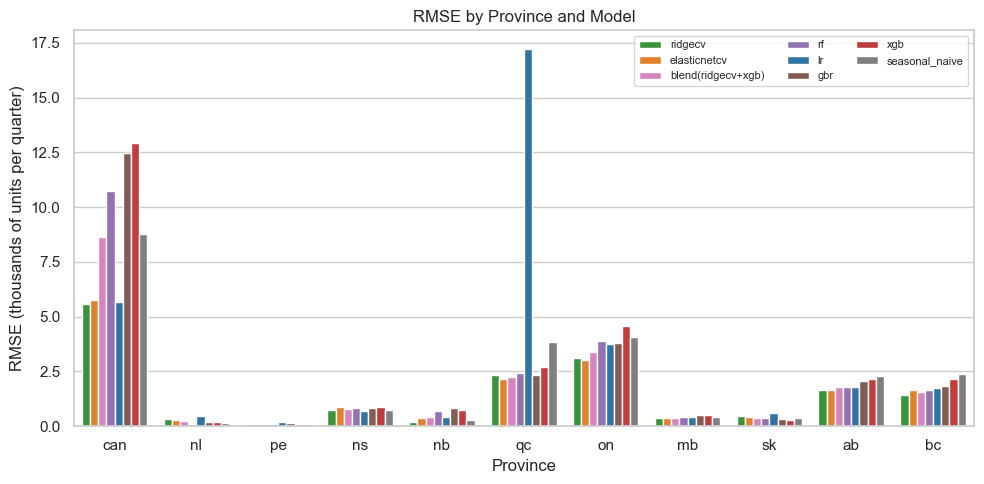

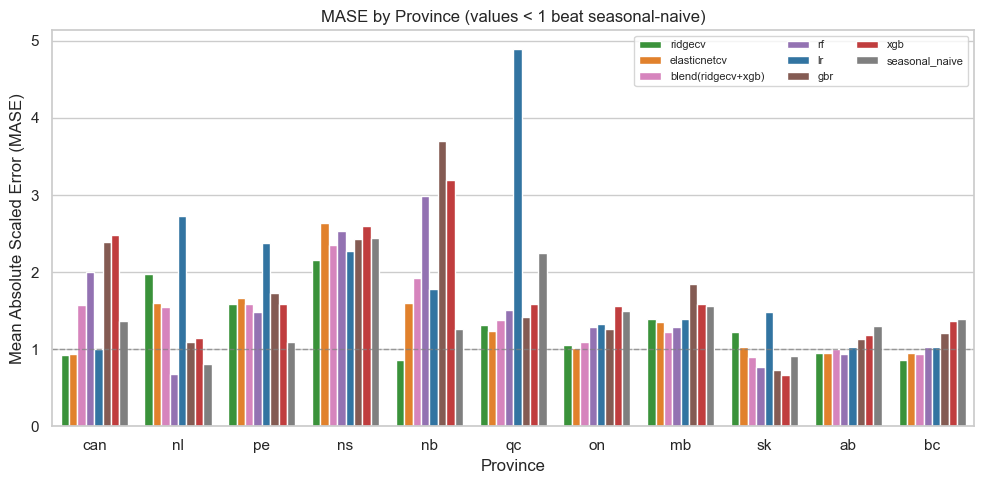

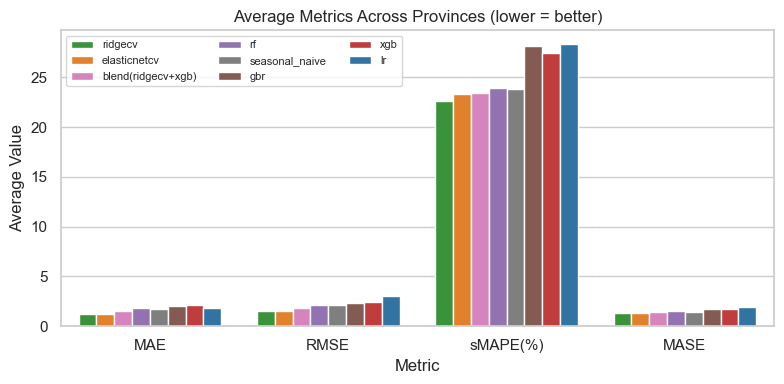

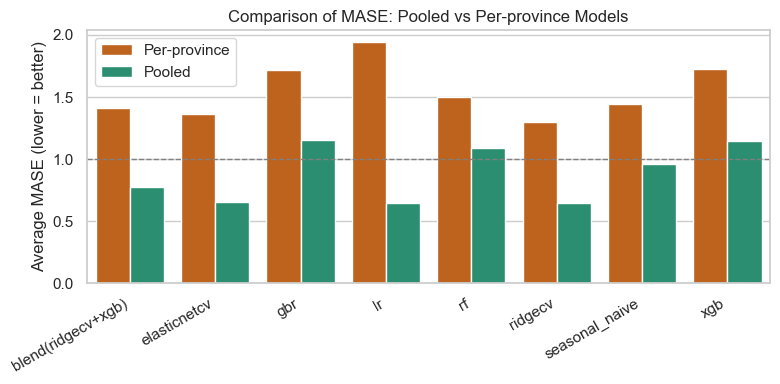

In [10]:
# %%
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_context("notebook")

# --- helper palette ---
model_palette = {
    "lr": "#1f77b4",
    "ridgecv": "#2ca02c",
    "elasticnetcv": "#ff7f0e",
    "rf": "#9467bd",
    "gbr": "#8c564b",
    "xgb": "#d62728",
    "blend(ridgecv+xgb)": "#e377c2",
    "seasonal_naive": "#7f7f7f",
}

# --- 1. Per-province RMSE ---
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(
    data=per_metrics,
    x="province", y="RMSE", hue="model",
    order=PROVINCES_ORDER,
    palette=model_palette, ax=ax
)
ax.set_title("RMSE by Province and Model")
ax.set_xlabel("Province")
ax.set_ylabel("RMSE (thousands of units per quarter)")
ax.legend(ncol=3, fontsize=8, frameon=True, title="")
plt.tight_layout()
plt.show()

# --- 2. Per-province MASE ---
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(
    data=per_metrics,
    x="province", y="MASE", hue="model",
    order=PROVINCES_ORDER,
    palette=model_palette, ax=ax
)
ax.axhline(1.0, color="gray", lw=1, ls="--", alpha=0.7)
ax.set_title("MASE by Province (values < 1 beat seasonal-naive)")
ax.set_xlabel("Province")
ax.set_ylabel("Mean Absolute Scaled Error (MASE)")
ax.legend(ncol=3, fontsize=8, frameon=True, title="")
plt.tight_layout()
plt.show()

# --- 3. Average metrics across provinces ---
agg_plot = agg.reset_index().melt(id_vars="model", var_name="Metric", value_name="Value")
fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(
    data=agg_plot, x="Metric", y="Value", hue="model",
    palette=model_palette, ax=ax
)
ax.set_title("Average Metrics Across Provinces (lower = better)")
ax.set_ylabel("Average Value")
ax.legend(ncol=3, fontsize=8, frameon=True, title="")
plt.tight_layout()
plt.show()

# --- 4. Optional: Pooled vs per-province ---
compare_df = pd.concat([
    pool_metrics.assign(level="Pooled"),
    per_metrics.assign(level="Per-province")
], ignore_index=True)

compare_avg = (
    compare_df.groupby(["level", "model"])
    .agg({"MAE": "mean", "RMSE": "mean", "MASE": "mean"})
    .reset_index()
)

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(
    data=compare_avg, x="model", y="MASE", hue="level",
    palette={"Pooled": "#1b9e77", "Per-province": "#d95f02"}, ax=ax
)
ax.axhline(1.0, color="gray", ls="--", lw=1)
ax.set_title("Comparison of MASE: Pooled vs Per-province Models")
ax.set_ylabel("Average MASE (lower = better)")
ax.set_xlabel("")
ax.legend(title="")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


In [11]:
# %%
from sklearn.metrics import r2_score
import matplotlib.dates as mdates

def best_model_by_rmse(metrics_df):
    """Return dict province -> best_model_name by RMSE."""
    return (
        metrics_df.sort_values(["province","RMSE"])
        .groupby("province")
        .head(1)
        .set_index("province")["model"]
        .to_dict()
    )

best_per_model = best_model_by_rmse(per_metrics)
best_per_model


{'ab': 'ridgecv',
 'bc': 'ridgecv',
 'can': 'ridgecv',
 'mb': 'elasticnetcv',
 'nb': 'ridgecv',
 'nl': 'rf',
 'ns': 'lr',
 'on': 'elasticnetcv',
 'pe': 'seasonal_naive',
 'qc': 'elasticnetcv',
 'sk': 'xgb'}

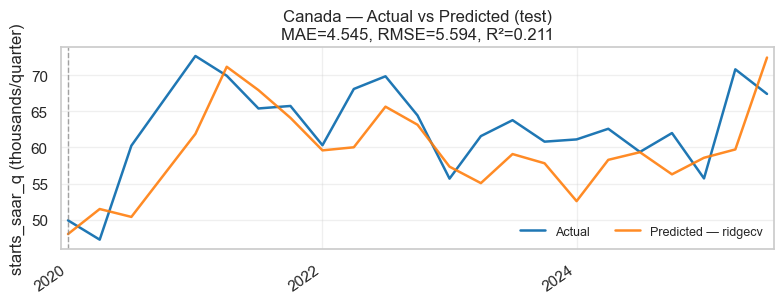

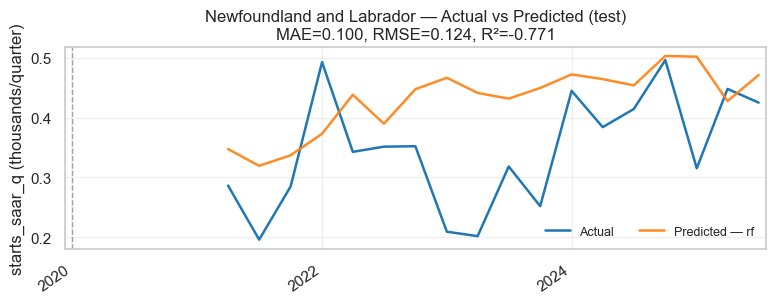

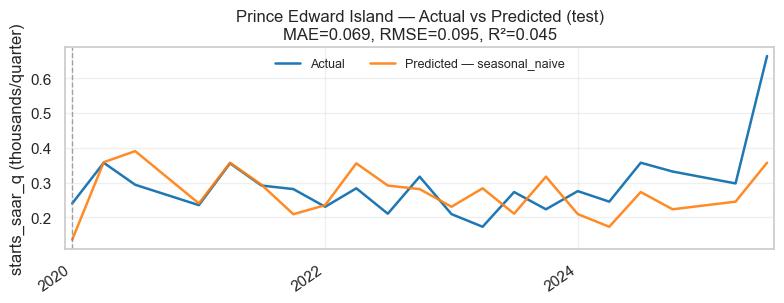

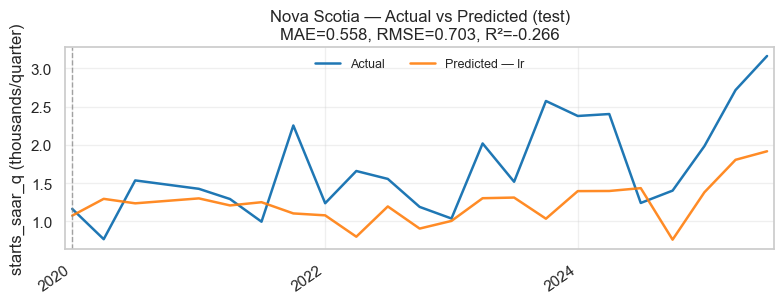

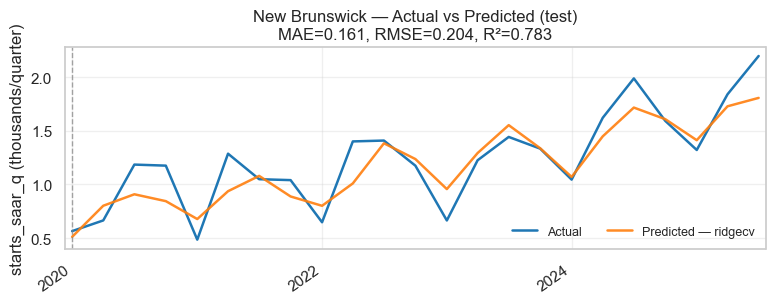

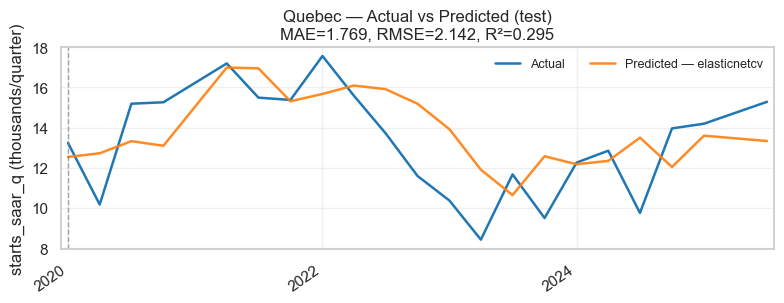

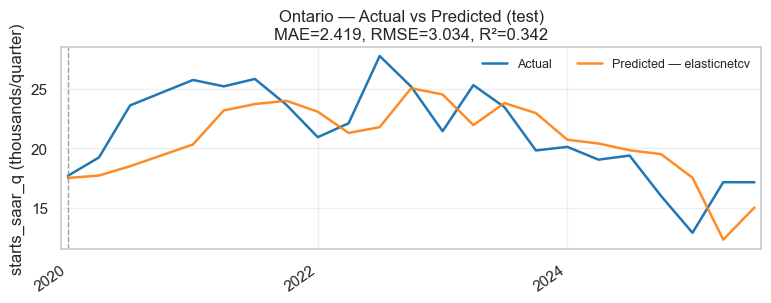

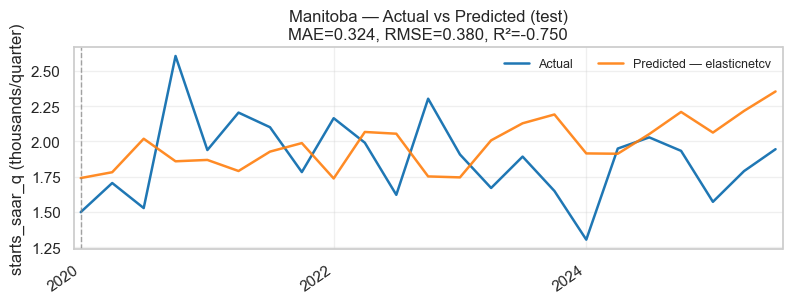

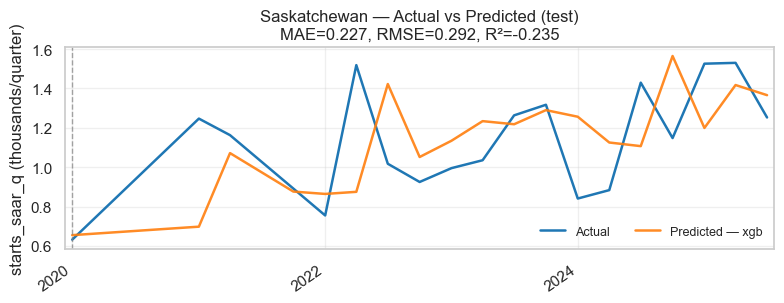

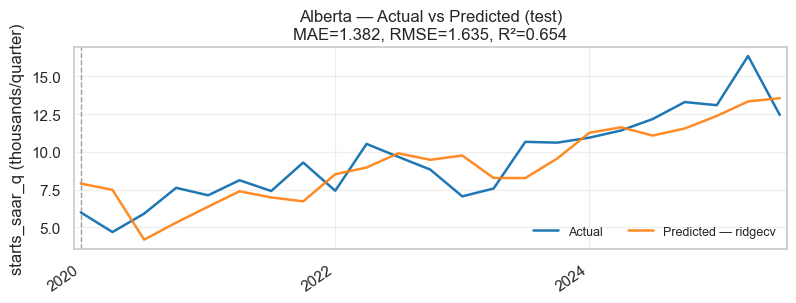

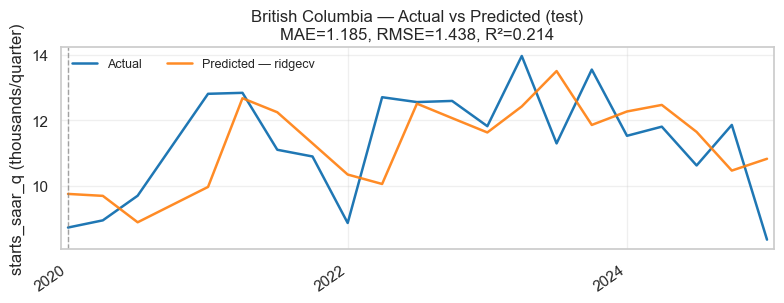

In [12]:
# %%
def plot_actual_vs_predicted_per_province(
    df_all,
    preds_store,
    best_models: dict,
    target_col: str = "starts_saar_q",
    provinces_order=None,
    year_tick_interval: int = 2,
    rotation: int = 30,
):
    """
    For each province, plot a line chart of Actual vs Predicted over the TEST period
    using that province's best model by RMSE.
    """
    provinces = provinces_order or sorted(best_models.keys())
    locator = mdates.YearLocator(base=year_tick_interval)
    formatter = mdates.DateFormatter('%Y')

    for p in provinces:
        if p not in preds_store:
            continue
        if p not in best_models:
            continue

        model_name = best_models[p]
        if model_name not in preds_store[p]:
            continue

        # test index used when evaluating this model
        test_idx = preds_store[p][model_name].index
        te = df_all.loc[test_idx].copy().sort_values("quarter")
        if te.empty:
            continue

        x = te["quarter"].dt.to_timestamp()
        y_true = te[target_col].values
        y_pred = preds_store[p][model_name].loc[te.index].values

        mae_val = np.mean(np.abs(y_true - y_pred))
        rmse_val = np.sqrt(np.mean((y_true - y_pred)**2))
        r2 = r2_score(y_true, y_pred)

        plt.figure(figsize=(8,3.2))
        ax = plt.gca()
        ax.plot(x, y_true, label="Actual", linewidth=1.8)
        ax.plot(x, y_pred, label=f"Predicted — {model_name}", linewidth=1.8, alpha=0.9)

        # Split line (train/test boundary)
        try:
            split_dt = pd.Period(SPLIT_POINT, freq="Q").to_timestamp()
            ax.axvline(split_dt, color="gray", ls="--", lw=1, alpha=0.7)
        except Exception:
            pass

        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        for lab in ax.get_xticklabels():
            lab.set_rotation(rotation); lab.set_ha("right")

        ax.grid(True, alpha=0.3)
        ax.margins(x=0.01)
        prov_name = PROVINCE_NAMES.get(p, p)
        ax.set_title(f"{prov_name} — Actual vs Predicted (test)\nMAE={mae_val:.3f}, RMSE={rmse_val:.3f}, R²={r2:.3f}")
        ax.set_ylabel(target_col + " (thousands/quarter)")
        ax.legend(frameon=False, fontsize=9, ncol=2)
        plt.tight_layout()
        plt.show()

# Use it:
plot_actual_vs_predicted_per_province(
    df_feat, per_preds, best_per_model,
    target_col=TARGET, provinces_order=PROVINCES_ORDER,
    year_tick_interval=2, rotation=35
)


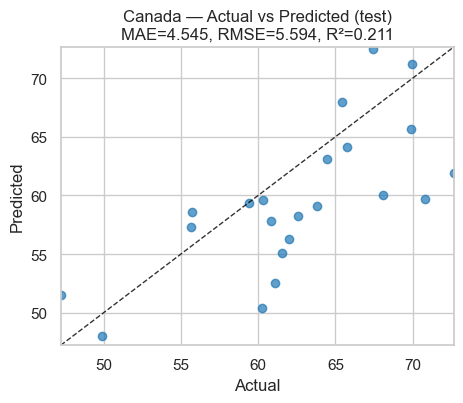

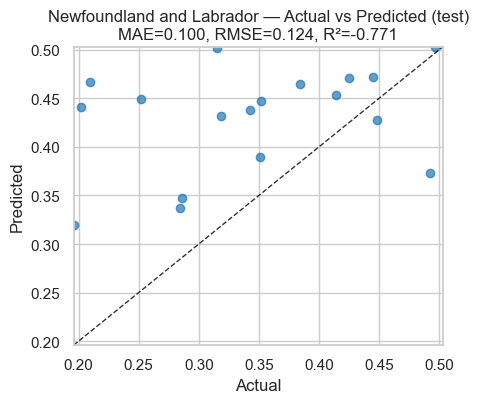

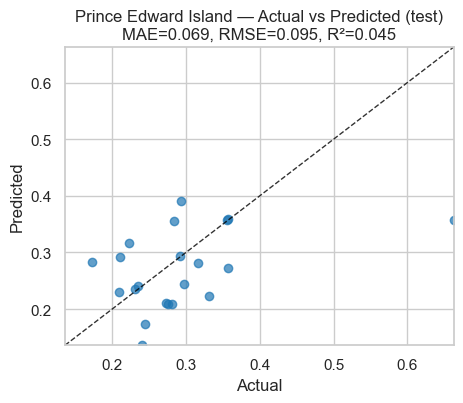

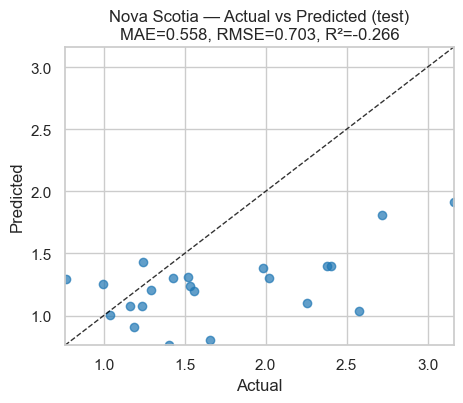

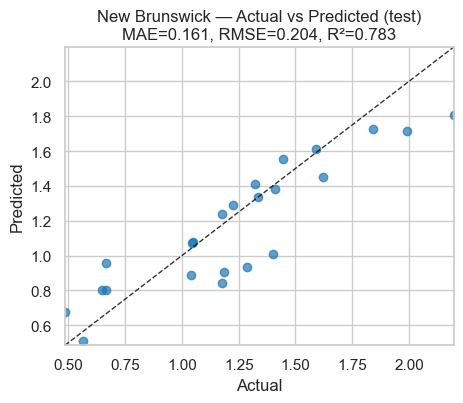

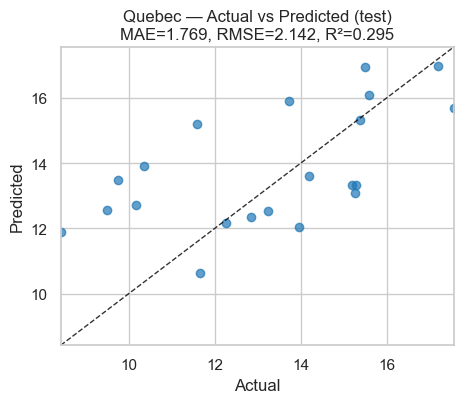

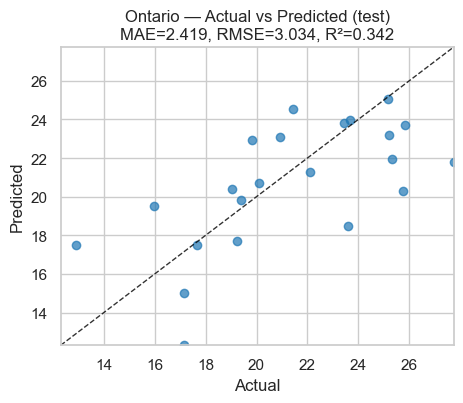

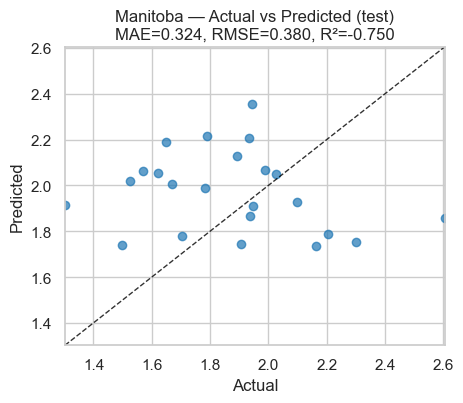

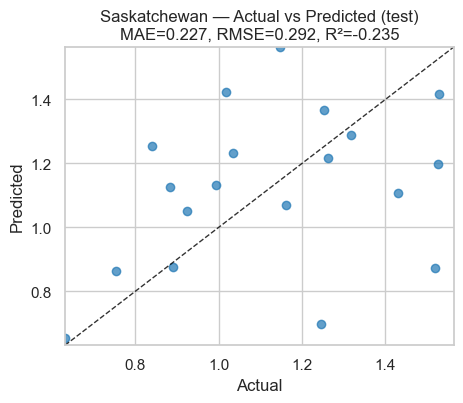

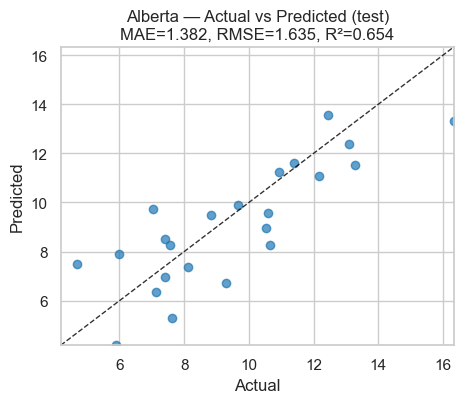

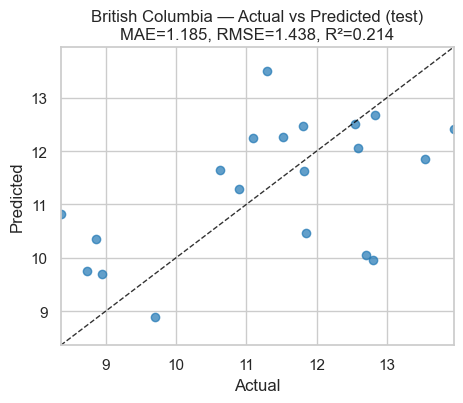

In [13]:
# %%
def scatter_actual_vs_predicted_per_province(
    df_all,
    preds_store,
    best_models: dict,
    target_col: str = "starts_saar_q",
    provinces_order=None
):
    provinces = provinces_order or sorted(best_models.keys())
    for p in provinces:
        if p not in preds_store or p not in best_models:
            continue
        model_name = best_models[p]
        if model_name not in preds_store[p]:
            continue

        test_idx = preds_store[p][model_name].index
        te = df_all.loc[test_idx].copy().sort_values("quarter")
        if te.empty:
            continue

        y_true = te[target_col].values
        y_pred = preds_store[p][model_name].loc[te.index].values

        mae_val = np.mean(np.abs(y_true - y_pred))
        rmse_val = np.sqrt(np.mean((y_true - y_pred)**2))
        r2 = r2_score(y_true, y_pred)

        lims = [
            np.nanmin([y_true.min(), y_pred.min()]),
            np.nanmax([y_true.max(), y_pred.max()])
        ]

        plt.figure(figsize=(4.8,4.2))
        plt.scatter(y_true, y_pred, alpha=0.7)
        plt.plot(lims, lims, 'k--', lw=1, alpha=0.8)  # 45° line
        plt.xlim(lims); plt.ylim(lims)
        plt.xlabel("Actual"); plt.ylabel("Predicted")
        prov_name = PROVINCE_NAMES.get(p, p)
        plt.title(f"{prov_name} — Actual vs Predicted (test)\nMAE={mae_val:.3f}, RMSE={rmse_val:.3f}, R²={r2:.3f}")
        plt.tight_layout()
        plt.show()

# Use it:
scatter_actual_vs_predicted_per_province(
    df_feat, per_preds, best_per_model,
    target_col=TARGET, provinces_order=PROVINCES_ORDER
)


In [14]:
# %%
# pick best pooled model by RMSE
best_pooled_model = (
    pool_metrics.sort_values("RMSE")
    .head(1)["model"]
    .iloc[0]
)
best_pooled_model


'lr'

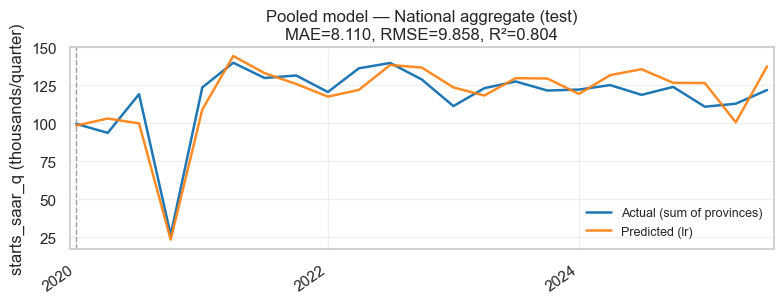

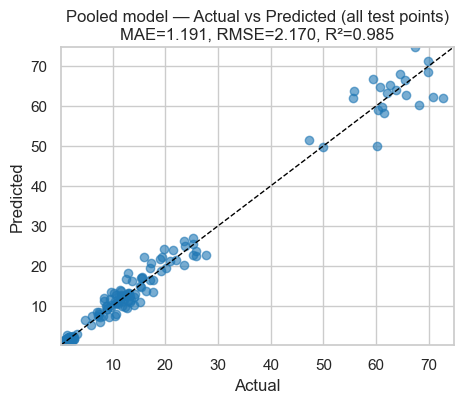

In [15]:
# %%
def plot_pooled_actual_vs_predicted(
    df_all,
    pooled_preds_store,
    model_name: str,
    target_col: str = "starts_saar_q",
    year_tick_interval: int = 2,
    rotation: int = 30
):
    if "pooled" not in pooled_preds_store or model_name not in pooled_preds_store["pooled"]:
        print(f"Model '{model_name}' not found in pooled predictions.")
        return

    test_idx = pooled_preds_store["pooled"][model_name].index
    te = df_all.loc[test_idx].copy().sort_values(["province","quarter"])
    if te.empty:
        print("Empty test slice for pooled model.")
        return

    # Option A: line plot for national aggregate (sum across provinces per quarter)
    agg = te.copy()
    agg["pred"] = pooled_preds_store["pooled"][model_name].loc[te.index].values
    nat = (
        agg.groupby("quarter")[[target_col, "pred"]]
        .sum()
        .reset_index()
        .sort_values("quarter")
    )
    x = nat["quarter"].dt.to_timestamp()

    locator = mdates.YearLocator(base=year_tick_interval)
    formatter = mdates.DateFormatter('%Y')

    plt.figure(figsize=(8,3.2))
    ax = plt.gca()
    ax.plot(x, nat[target_col].values, label="Actual (sum of provinces)", linewidth=1.8)
    ax.plot(x, nat["pred"].values, label=f"Predicted ({model_name})", linewidth=1.8, alpha=0.9)

    try:
        split_dt = pd.Period(SPLIT_POINT, freq="Q").to_timestamp()
        ax.axvline(split_dt, color="gray", ls="--", lw=1, alpha=0.7)
    except Exception:
        pass

    ax.xaxis.set_major_locator(locator); ax.xaxis.set_major_formatter(formatter)
    for lab in ax.get_xticklabels():
        lab.set_rotation(rotation); lab.set_ha("right")

    mae_val = np.mean(np.abs(nat[target_col].values - nat["pred"].values))
    rmse_val = np.sqrt(np.mean((nat[target_col].values - nat["pred"].values)**2))
    r2 = r2_score(nat[target_col].values, nat["pred"].values)

    ax.grid(True, alpha=0.3); ax.margins(x=0.01)
    ax.set_title(f"Pooled model — National aggregate (test)\nMAE={mae_val:.3f}, RMSE={rmse_val:.3f}, R²={r2:.3f}")
    ax.set_ylabel(target_col + " (thousands/quarter)")
    ax.legend(frameon=False, fontsize=9)
    plt.tight_layout()
    plt.show()

    # Option B: scatter across all test points (all provinces)
    y_true = te[target_col].values
    y_pred = pooled_preds_store["pooled"][model_name].loc[te.index].values
    mae_val = np.mean(np.abs(y_true - y_pred))
    rmse_val = np.sqrt(np.mean((y_true - y_pred)**2))
    r2 = r2_score(y_true, y_pred)

    lims = [np.nanmin([y_true.min(), y_pred.min()]),
            np.nanmax([y_true.max(), y_pred.max()])]

    plt.figure(figsize=(4.8,4.2))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot(lims, lims, 'k--', lw=1)
    plt.xlim(lims); plt.ylim(lims)
    plt.title(f"Pooled model — Actual vs Predicted (all test points)\nMAE={mae_val:.3f}, RMSE={rmse_val:.3f}, R²={r2:.3f}")
    plt.xlabel("Actual"); plt.ylabel("Predicted")
    plt.tight_layout()
    plt.show()

# Use it:
plot_pooled_actual_vs_predicted(
    df_feat, pool_preds, best_pooled_model, target_col=TARGET,
    year_tick_interval=2, rotation=35
)


### A

In [16]:
# %%
def rolling_origin_eval(data, feature_cols, province="can", start_year=2005, end_year=2019):
    sub = data[data["province"]==province].dropna(subset=feature_cols + [TARGET]).copy()
    rows = []
    reg = build_model_registry()
    for year in range(start_year, end_year+1):
        split = f"{year}Q1"
        tr = sub[sub["quarter"] < split]
        te = sub[(sub["quarter"] >= split) & (sub["quarter"] < f"{year+1}Q1")]
        if tr.empty or te.empty: continue
        X_tr, y_tr = tr[feature_cols].values, tr[TARGET].values
        X_te, y_te = te[feature_cols].values, te[TARGET].values
        for name, mdl in reg.items():
            mdl.fit(X_tr, y_tr)
            yhat = mdl.predict(X_te)
            rows.append({"year": year, "model": name, "MAE": mae(y_te, yhat), "RMSE": rmse(y_te, yhat)})
    out = pd.DataFrame(rows)
    if out.empty: return out
    print(f"Rolling-origin summary — {PROVINCE_NAMES.get(province, province)}")
    display(out.groupby("model").mean().sort_values("RMSE"))
    return out

# Example (can take time):
_ = rolling_origin_eval(df_feat, BASE_FEATS, province="can", start_year=2005, end_year=2019)


/opt/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.235e-01, tolerance: 4.009e-01
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.257e+01, tolerance: 4.009e-01
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/erdos_ds_environment/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sc

Rolling-origin summary — Canada


,year,MAE,RMSE
model,,,
elasticnetcv,2012.0,3.294371,3.870357
ridgecv,2012.0,3.427082,4.055606
rf,2012.0,3.577686,4.452595
lr,2012.0,3.862835,4.580024
xgb,2012.0,4.236018,4.922229
gbr,2012.0,4.173252,4.940667


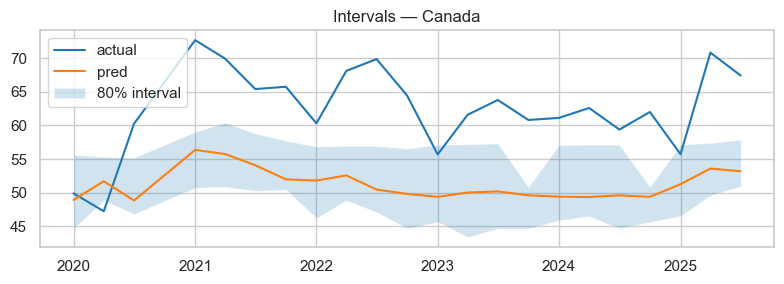

In [17]:
# %%
def quantile_gbr(trainX, trainy, testX, alpha):
    q = GradientBoostingRegressor(loss="quantile", alpha=alpha, n_estimators=800, learning_rate=0.03, max_depth=3, random_state=RANDOM_STATE)
    q.fit(trainX, trainy); return q.predict(testX)

def demo_intervals(data, feature_cols, province="can"):
    sub = data[data["province"]==province].dropna(subset=feature_cols + [TARGET]).copy()
    tr, te = chrono_split(sub, SPLIT_POINT)
    if tr.empty or te.empty:
        print("Not enough data for intervals demo."); return
    X_tr, y_tr = tr[feature_cols].values, tr[TARGET].values
    X_te, y_te = te[feature_cols].values, te[TARGET].values

    mid = GradientBoostingRegressor(n_estimators=800, learning_rate=0.03, max_depth=3, random_state=RANDOM_STATE).fit(X_tr, y_tr)
    yhat = mid.predict(X_te)
    ylo = quantile_gbr(X_tr, y_tr, X_te, alpha=0.1)
    yhi = quantile_gbr(X_tr, y_tr, X_te, alpha=0.9)

    x = _to_datetime_from_period(te["quarter"])
    plt.figure(figsize=(8,3))
    plt.plot(x, y_te, label="actual")
    plt.plot(x, yhat, label="pred")
    plt.fill_between(x, ylo, yhi, alpha=0.2, label="80% interval")
    plt.title(f"Intervals — {PROVINCE_NAMES.get(province, province)}"); plt.legend(); plt.tight_layout(); plt.show()

# Example:
demo_intervals(df_feat, BASE_FEATS, province="can")


In [18]:
# %%
def train_final_models_per_province(data, feature_cols):
    reg = build_model_registry()
    final_models = {}
    for p in data["province"].unique():
        sub = data[data["province"]==p].dropna(subset=feature_cols + [TARGET]).copy()
        if sub.empty: continue
        mdl_name = "xgb" if HAS_XGB else ("lgbm" if HAS_LGBM else "ridgecv")
        mdl = reg[mdl_name]
        mdl.fit(sub[feature_cols].values, sub[TARGET].values)
        final_models[p] = (mdl_name, mdl)
    return final_models

def forecast_future(trained_models, df_hist, future_df, feature_cols, seasonality=4):
    fut = future_df.copy().sort_values(["province","quarter"])
    # If only 'population' provided, derive pop_change_q and needed_units_q
    if "pop_change_q" not in fut.columns and "population" in fut.columns:
        fut["pop_change_q"] = fut.groupby("province")["population"].diff()
    if "needed_units_q" not in fut.columns:
        fut["needed_units_q"] = fut["pop_change_q"] / AHS

    out = []
    for p, g in fut.groupby("province"):
        if p not in trained_models: continue
        mdl_name, mdl = trained_models[p]
        hist = df_hist[df_hist["province"]==p].sort_values("quarter")
        # init lag buffer from history
        last = hist[TARGET].tail(seasonality).tolist()
        g = g.copy()
        preds = []
        for idx, row in g.iterrows():
            # fill minimal required features (lags, calendar)
            for l in [1,2,4]:
                g.loc[idx, f"{TARGET}_lag{l}"] = last[-l] if len(last) >= l else np.nan
            g.loc[idx, "year"] = row["quarter"].year
            qn = row["quarter"].quarter
            g.loc[idx, "q_2"] = 1 if qn==2 else 0
            g.loc[idx, "q_3"] = 1 if qn==3 else 0
            g.loc[idx, "q_4"] = 1 if qn==4 else 0
            # basic interactions (safe)
            g.loc[idx, "pop_change_rate"] = np.nan
            if pd.notna(row.get("population", np.nan)) and row.get("population", 0) != 0:
                g.loc[idx, "pop_change_rate"] = row["pop_change_q"]/row["population"]
            g.loc[idx, "starts_per_need"] = np.nan  # unknown (depends on target), fine to leave NaN

            # rollings omitted in forecast (or precompute with buffer if desired)
            for w in [2,4,8]:
                g.loc[idx, f"starts_ma{w}"] = np.nan
                g.loc[idx, f"pop_change_ma{w}"] = np.nan
                g.loc[idx, f"need_ma{w}"] = np.nan

            x = g.loc[idx, feature_cols].values.reshape(1,-1)
            yhat = mdl.predict(x)[0]
            preds.append(yhat)
            last.append(yhat)

        g["pred_starts_saar_q"] = preds
        g["pred_dwelling_starts"] = g["pred_starts_saar_q"] * 1000.0
        g["hai_pred"] = g["pred_dwelling_starts"] / g["needed_units_q"]
        out.append(g)

    return pd.concat(out).sort_values(["province","quarter"]).reset_index(drop=True)

# Example usage:
# future_pop_df = ...  # columns: province, quarter (PeriodIndex), population (and/or pop_change_q)
# final_models = train_final_models_per_province(df_feat, BASE_FEATS)
# preds_future = forecast_future(final_models, df_feat, future_pop_df, BASE_FEATS)
# display(preds_future.head())


In [19]:
import matplotlib.dates as mdates
from itertools import cycle

def _to_datetime_from_period(q: pd.Series) -> pd.Series:
    return q.dt.to_timestamp()

def _select_provinces(df, provinces_order=None):
    if provinces_order is None:
        return sorted(df["province"].unique())
    return [p for p in provinces_order if p in df["province"].unique()]

def plot_time_series_overlay(
    df: pd.DataFrame,
    col: str,
    provinces: list | None = None,
    title: str | None = None,
    year_tick_interval: int = 2,
    rotation: int = 30,
    alpha: float = 0.8,
    linewidth: float = 1.6,
    show_legend: bool = True,
    legend_cols: int = 3,
    figsize: tuple = (9, 4)
):
    """
    Overlay a single time-series column for multiple provinces on ONE axis.
    Uses original province names in legend.
    """
    provs = provinces or _select_provinces(df, PROVINCES_ORDER)
    plt.figure(figsize=figsize)
    ax = plt.gca()

    # Ticks/formatting
    locator = mdates.YearLocator(base=year_tick_interval)
    formatter = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    for p in provs:
        sub = df[df["province"]==p].sort_values("quarter").copy()
        if sub.empty or col not in sub.columns: 
            continue
        x = _to_datetime_from_period(sub["quarter"])
        y = sub[col].values
        ax.plot(
            x, y,
            label=PROVINCE_NAMES.get(p, p),
            linewidth=linewidth,
            alpha=alpha,
        )

    for label in ax.get_xticklabels():
        label.set_rotation(rotation)
        label.set_ha("right")

    ax.grid(True, alpha=0.3)
    ax.margins(x=0.01)
    ax.set_title(title or f"{col} — overlay by province")
    ax.set_ylabel(col)

    if show_legend:
        ax.legend(ncol=legend_cols, fontsize=8, frameon=False)
    plt.tight_layout()
    plt.show()


def plot_lag_corr_multi(
    df: pd.DataFrame,
    provinces: list | None = None,
    target_col: str = "starts_saar_q",
    driver_col: str = "pop_change_q",
    max_lag: int = 8,
    use_lines: bool = True,
    alpha: float = 0.8,
    linewidth: float = 1.8,
    marker: str = "o",
    figsize: tuple = (9, 4)
):
    """
    Plot correlation between target and lagged driver for multiple provinces on ONE axis.
    Each province gets its own color. Original province names in legend.
    Corr(lag) = corr( target_t , driver_{t - lag} )
    """
    provs = provinces or _select_provinces(df, PROVINCES_ORDER)
    lags = np.arange(0, max_lag+1)

    plt.figure(figsize=figsize)
    ax = plt.gca()

    color_cycler = cycle(plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0','C1','C2','C3','C4','C5','C6','C7']))

    for p in provs:
        sub = df[df["province"]==p].copy()
        sub = sub.dropna(subset=[target_col, driver_col]).sort_values("quarter")
        if sub.empty:
            continue

        cors = []
        s_target = sub[target_col].reset_index(drop=True)
        s_driver = sub[driver_col].reset_index(drop=True)
        for lag in lags:
            if lag > 0:
                c = pd.Series(s_target).corr(pd.Series(s_driver).shift(lag))
            else:
                c = pd.Series(s_target).corr(pd.Series(s_driver))
            cors.append(c)

        color = next(color_cycler)
        label = PROVINCE_NAMES.get(p, p)
        if use_lines:
            ax.plot(lags, cors, label=label, alpha=alpha, linewidth=linewidth, marker=marker)
        else:
            ax.bar(lags + (0.1 * list(provs).index(p)), cors, width=0.1, alpha=alpha, label=label, color=color)

    ax.axhline(0, color="gray", linewidth=1, alpha=0.6)
    ax.set_xlabel(f"Lag of {driver_col} (quarters)")
    ax.set_ylabel("Correlation")
    ax.set_title(f"Lag correlation: {target_col} vs lagged {driver_col}")
    ax.grid(True, axis="y", alpha=0.3)
    ax.set_xticks(lags)
    ax.legend(ncol=3, fontsize=8, frameon=False)
    plt.tight_layout()
    plt.show()


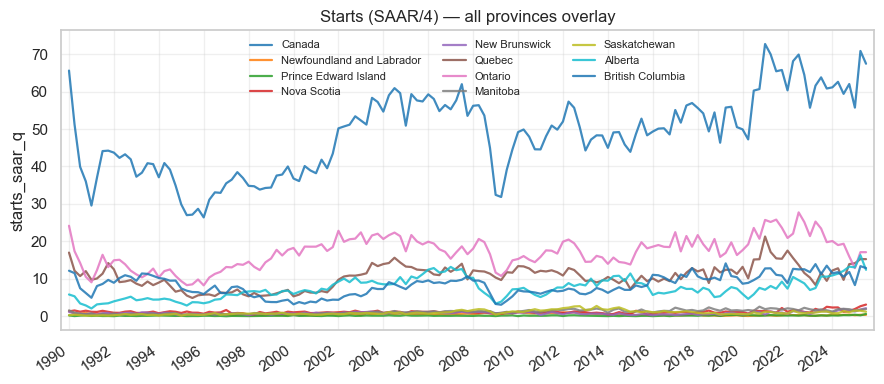

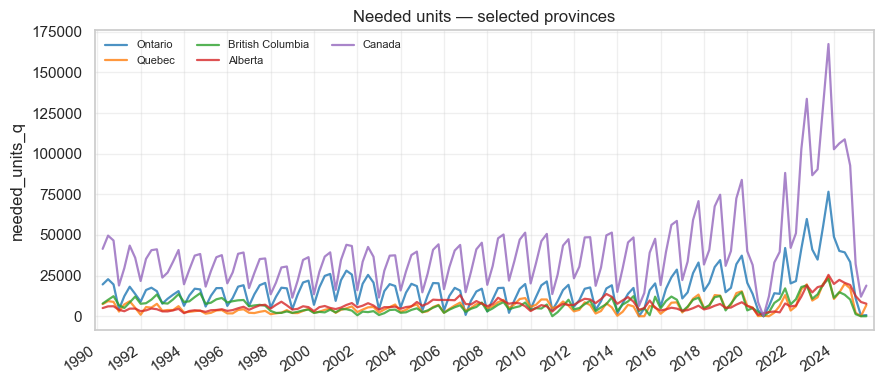

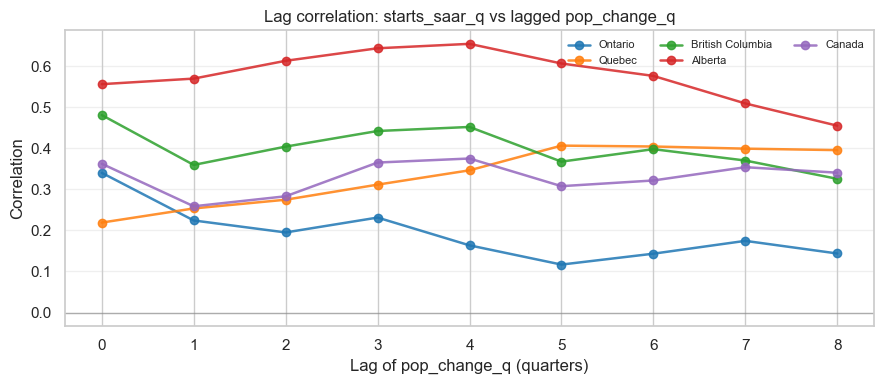

In [20]:
# Overlay starts across all provinces
plot_time_series_overlay(
    df, "starts_saar_q",
    provinces=PROVINCES_ORDER,
    title="Starts (SAAR/4) — all provinces overlay",
    year_tick_interval=2, rotation=35, alpha=0.85
)

# Overlay needed units
plot_time_series_overlay(
    df, "needed_units_q",
    provinces=["on","qc","bc","ab","can"],
    title="Needed units — selected provinces",
    year_tick_interval=2, rotation=35, alpha=0.8
)

# Multi-province lag correlation (lines)
plot_lag_corr_multi(
    df,
    provinces=["on","qc","bc","ab","can"],
    target_col="starts_saar_q",
    driver_col="pop_change_q",
    max_lag=8,
    use_lines=True,
    alpha=0.85
)


#### B

In [21]:
# %%
# define a province and build train/test for that province
PROV = "can"   # change to "on", "qc", etc.

sub = df_feat[df_feat["province"] == PROV].dropna(subset=BASE_FEATS + [TARGET]).copy()
tr = sub[sub["quarter"] < SPLIT_POINT].copy()
te = sub[sub["quarter"] >= SPLIT_POINT].copy()

print(PROV, tr.shape, te.shape)

# now you can do:
X_tr, X_te = tr[BASE_FEATS].values, te[BASE_FEATS].values
y_tr, y_te = tr[TARGET].values, te[TARGET].values
y_low, y_mid, y_high = fit_quantile_model(X_tr, y_tr, X_te, alpha=0.9)

# quick plot
x = te["quarter"].dt.to_timestamp()
plt.figure(figsize=(8,3))
plt.plot(x, y_te, label="Actual", lw=1.6)
plt.plot(x, y_mid, label="Predicted (median)", lw=1.6)
plt.fill_between(x, y_low, y_high, alpha=0.25, label="90% PI")
plt.title(f"Quantile intervals — {PROVINCE_NAMES.get(PROV, PROV)}")
plt.xticks(rotation=30, ha="right")
plt.legend(); plt.tight_layout(); plt.show()


can (116, 36) (22, 36)


NameError: name 'fit_quantile_model' is not defined

pooled (1252, 36) (250, 36)


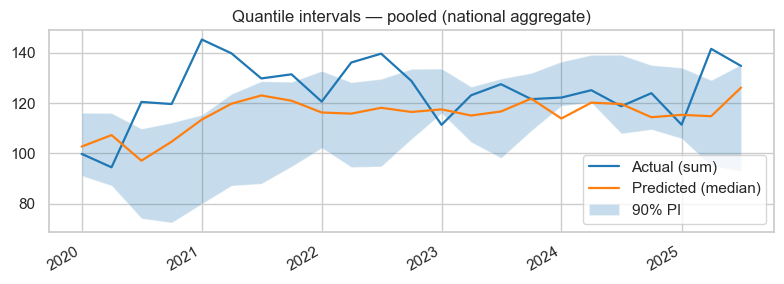

In [ ]:
# %%
# pooled train/test across all provinces
pooled = df_feat.dropna(subset=BASE_FEATS + [TARGET]).copy()
tr = pooled[pooled["quarter"] < SPLIT_POINT].copy()
te = pooled[pooled["quarter"] >= SPLIT_POINT].copy()

print("pooled", tr.shape, te.shape)

X_tr, X_te = tr[BASE_FEATS].values, te[BASE_FEATS].values
y_tr, y_te = tr[TARGET].values, te[TARGET].values
y_low, y_mid, y_high = fit_quantile_model(X_tr, y_tr, X_te, alpha=0.9)

# aggregate to national (sum of provinces per quarter) for a clean line plot
tmp = te[["quarter", TARGET]].copy()
tmp["pred"] = y_mid
tmp["lo"] = y_low
tmp["hi"] = y_high
nat = (tmp.groupby("quarter")[["starts_saar_q","pred","lo","hi"]]
       .sum()
       .reset_index()
       .sort_values("quarter"))

x = nat["quarter"].dt.to_timestamp()
plt.figure(figsize=(8,3))
plt.plot(x, nat["starts_saar_q"], label="Actual (sum)", lw=1.6)
plt.plot(x, nat["pred"], label="Predicted (median)", lw=1.6)
plt.fill_between(x, nat["lo"], nat["hi"], alpha=0.25, label="90% PI")
plt.title("Quantile intervals — pooled (national aggregate)")
plt.xticks(rotation=30, ha="right")
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
# %% Helper to align feature columns for sklearn pipelines
def get_fit_feature_order(estimator):
    """
    Returns the exact feature order the fitted estimator expects.
    Works for Pipelines and bare estimators on recent sklearn versions.
    """
    if hasattr(estimator, "feature_names_in_"):
        return list(estimator.feature_names_in_)
    # Pipeline case: after fit, Pipeline also has feature_names_in_
    if hasattr(estimator, "named_steps"):
        for step in estimator.named_steps.values():
            if hasattr(step, "feature_names_in_"):
                return list(step.feature_names_in_)
    # Fallback: use your BASE_FEATS (last resort)
    return list(BASE_FEATS)

def align_X(df_like, estimator):
    cols = get_fit_feature_order(estimator)
    # Reindex to the exact order; if any column missing, create it as NaN
    X = df_like.reindex(columns=cols)
    # Ensure numeric dtypes (objects can trigger errors)
    for c in X.columns:
        if not np.issubdtype(X[c].dtype, np.number):
            X[c] = pd.to_numeric(X[c], errors="coerce")
    return X


# 1) Train
mdl = build_model_registry()["ridgecv"]
CUTOFF = "2025Q1"
train = df_feat[df_feat["quarter"] < CUTOFF].dropna(subset=BASE_FEATS + [TARGET]).copy()
X_tr = train[BASE_FEATS]
y_tr = train[TARGET].values
mdl.fit(X_tr, y_tr)

# 2) Build future scenario (your same code)… produces `forecast` DataFrame

# 3) ALIGN features before predict
X_fc = align_X(forecast[BASE_FEATS], mdl)
forecast["y_pred"] = mdl.predict(X_fc)




ValueError: cannot reindex on an axis with duplicate labels